In [50]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Augmentation

In [95]:
train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                   rotation_range=30,
                                   horizontal_flip=True,
#                                    shear_range =20 ,
                                   brightness_range = [0.8,1.2]
                                )
                                  
val_datagen = ImageDataGenerator(rescale=1./255,
#                                 shear_range=20
                                )

In [96]:
#Batch Size and Image Size
batch_sz = 256
sz = 48

train_generator = train_datagen.flow_from_directory('../input/fer-dsc-v3/final_data_v5/final_data_v5/Train',
                                                    batch_size = batch_sz,
                                                    class_mode='categorical',
                                                    target_size=(sz,sz))

val_generator = val_datagen.flow_from_directory('../input/fer-dsc-v3/final_data_v5/final_data_v5/Test',
                                                    batch_size = batch_sz,
                                                    class_mode='categorical',
                                                    target_size=(sz,sz))

Found 14207 images belonging to 4 classes.
Found 1731 images belonging to 4 classes.


### Call Back

In [97]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.74):
#             if(logs.get('accuracy')>78):
                print("\nReached 74% val_accuracy, so cancelling training!")
                self.model.stop_training = True
callbacks = myCallback()

## Transfer Learning

In [98]:
from keras.applications.vgg16 import VGG16

In [124]:
pre_model = VGG16(include_top = False,
                 weights = 'imagenet',
                 input_shape = (48,48,3))

In [125]:
for layer in pre_model.layers:
    layer.trainable=False

In [126]:
last_output = pre_model.output

## Model

In [127]:
x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.Dense(32,activation= 'relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
# x = tf.keras.layers.Dense(16,activation= 'relu')(x)
# x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(4,activation='softmax',name = 'Output')(x)

In [128]:
model = tf.keras.Model(pre_model.input, x)

### Hyperparameters

In [129]:
#Learning Rate and Epochs for Model Warm-up
lr1 = 1e-5
e1 = 10

#Learning Rate and Epochs for Model Training
lr2 = 1e-4
e2 = 17

## Warming up the model

In [130]:
opt = tf.keras.optimizers.Adam(learning_rate = lr1)
model.compile(optimizer = opt,loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [131]:
history = model.fit(train_generator,
                   validation_data = val_generator,
                   validation_steps = val_generator.samples // val_generator.batch_size,
                    epochs = e1) 

Epoch 1/10
56/56 [==============================] - 24s 428ms/step - loss: 1.5912 - accuracy: 0.2241 - val_loss: 1.4939 - val_accuracy: 0.2207
Epoch 2/10
56/56 [==============================] - 25s 444ms/step - loss: 1.5647 - accuracy: 0.2285 - val_loss: 1.4743 - val_accuracy: 0.2227
Epoch 3/10
56/56 [==============================] - 24s 430ms/step - loss: 1.5407 - accuracy: 0.2314 - val_loss: 1.4618 - val_accuracy: 0.2305
Epoch 4/10
56/56 [==============================] - 24s 422ms/step - loss: 1.5295 - accuracy: 0.2266 - val_loss: 1.4531 - val_accuracy: 0.2318
Epoch 5/10
56/56 [==============================] - 24s 437ms/step - loss: 1.5156 - accuracy: 0.2370 - val_loss: 1.4410 - val_accuracy: 0.2357
Epoch 6/10
56/56 [==============================] - 24s 421ms/step - loss: 1.5005 - accuracy: 0.2383 - val_loss: 1.4359 - val_accuracy: 0.2383
Epoch 7/10
56/56 [==============================] - 25s 439ms/step - loss: 1.4979 - accuracy: 0.2322 - val_loss: 1.4314 - val_accuracy: 0.2454

## Training the model

In [132]:
for layer in model.layers:
    layer.trainable = True
#print(model.summary())

In [133]:
opt1 = tf.keras.optimizers.Adam(learning_rate = lr2)
model.compile(optimizer = opt1, loss='categorical_crossentropy', metrics=['accuracy'])

In [134]:
history1 = model.fit(train_generator,
                    validation_data = val_generator,
                    validation_steps = val_generator.samples // val_generator.batch_size,
                    epochs = e2,
                    callbacks = [callbacks])

Epoch 1/17
56/56 [==============================] - 25s 453ms/step - loss: 1.3000 - accuracy: 0.3769 - val_loss: 1.1062 - val_accuracy: 0.5247
Epoch 2/17
56/56 [==============================] - 26s 467ms/step - loss: 1.0924 - accuracy: 0.5228 - val_loss: 0.9491 - val_accuracy: 0.5964
Epoch 3/17
56/56 [==============================] - 25s 444ms/step - loss: 0.9901 - accuracy: 0.5840 - val_loss: 0.8767 - val_accuracy: 0.6257
Epoch 4/17
56/56 [==============================] - 26s 457ms/step - loss: 0.9079 - accuracy: 0.6272 - val_loss: 0.8246 - val_accuracy: 0.6549
Epoch 5/17
56/56 [==============================] - 25s 452ms/step - loss: 0.8802 - accuracy: 0.6437 - val_loss: 0.7893 - val_accuracy: 0.6738
Epoch 6/17
56/56 [==============================] - 26s 458ms/step - loss: 0.8291 - accuracy: 0.6662 - val_loss: 0.8001 - val_accuracy: 0.6647
Epoch 7/17
56/56 [==============================] - 25s 455ms/step - loss: 0.7999 - accuracy: 0.6776 - val_loss: 0.7660 - val_accuracy: 0.6829

### Training Summary

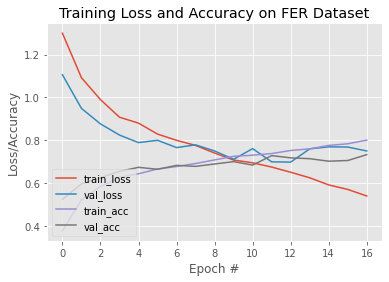

In [136]:
N = e2
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history1.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history1.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history1.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history1.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on FER Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

## Saving model as Frozen Graph

In [137]:
# Tensorflow 2.x
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
 
# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
 
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
 
# Print out model inputs and outputs
print("Frozen model inputs: ", frozen_func.inputs)
print("Frozen model outputs: ", frozen_func.outputs)
 
# Save frozen graph to disk
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="VGG16_1e-5_10_1e-4_17(gap,32,4).pb",
                  as_text=False)

Frozen model inputs:  [<tf.Tensor 'x:0' shape=(None, 48, 48, 3) dtype=float32>]
Frozen model outputs:  [<tf.Tensor 'Identity:0' shape=(None, 4) dtype=float32>]


'./frozen_models/VGG16_1e-5_10_1e-4_17(gap,32,4).pb'

## For Onnx conversion

In [26]:
# import onnxmltools
# output_onnx_model = './VGG16.onnx'
# onnx_model = onnxmltools.convert_keras(model)
# onnxmltools.utils.save_model(onnx_model, output_onnx_model)